# Альберт Халгатян 

# Группа: М80-107М

# Введение в нейронные сети

## Эпизод 2а: Многослойный персептрон на TensorFlow и Keras

Дмитрий Сошников | dmitri@soshnikov.com

http://github.com/shwars/NeuroWorkshop
-> Notebooks -> IntroKerasTF.ipynb

In [1]:
import tensorflow as tf
import numpy as np
print(tf.__version__)
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split
import random

2.5.0


## Пример
Рассмотрим пример двухмерной задачи классификации на 2 класса. Примером такой задачи может быть классификация опухоли на 2 типа - доброкачественная и злокачественная, в зависимости от её размера и возраста.

Сгенерируем тестовые данные случайным образом:


In [2]:
np.random.seed(0) # pick the seed for reproducability - change it to explore the effects of random variations

n = 1000
X, Y = make_classification(n_samples = n, n_features=2,
                           n_redundant=0, n_informative=2, flip_y=0.2,class_sep=1)
X = X.astype(np.float32)
Y = Y.astype(np.int32)

train_x, test_x, train_labels, valid_labels = train_test_split(X, Y, test_size=0.33, random_state=42)

## Используем оптимизаторы TensorFlow

Tensorflow достаточно плотно интегрирован с библиотекой Keras, которая содержит в себе множество полезного. Например, мы можем использовать оптимизаторы, реализующие немного другие алгоритмы обучения, чем градиентный спуск.

Также попробуем выводить точность на всех этапах обучения.

In [3]:
dataset = tf.data.Dataset.from_tensor_slices((train_x, train_labels.astype(np.float32)))
dataset = dataset.batch(batch_size=150)
valid_labels = valid_labels.astype(np.float32)

optimizer = tf.keras.optimizers.Adam(0.01)

learning_rate = 0.05

W = tf.Variable(tf.random.normal(shape=(2,1)))
b = tf.Variable(tf.zeros(shape=(1,),dtype=tf.float32))

@tf.function
def train_on_batch(x_train, x_test, y_train, y_test):
  vars = [W, b]
  with tf.GradientTape() as tape:
    z = tf.sigmoid(tf.matmul(x_train, W) + b)
    z_test = tf.sigmoid(tf.matmul(x_test, W) + b)

    loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(z,y_train))

    correct_prediction_train = tf.equal(tf.round(y_train), tf.round(z))
    acc_train = tf.reduce_mean(tf.cast(correct_prediction_train, tf.float32))

    correct_prediction_test = tf.equal(tf.round(y_test), tf.round(z_test))
    acc_test = tf.reduce_mean(tf.cast(correct_prediction_test, tf.float32))

    grads = tape.gradient(loss, vars)
    optimizer.apply_gradients(zip(grads,vars))
  return loss, acc_train, acc_test

acc_train_m = list()
acc_test_m = list()
for epoch in range(60):
  for step, (x, y_train) in enumerate(dataset):
    loss, acc_train, acc_test = train_on_batch(tf.reshape(x,(-1,2)), tf.reshape(test_x,(-1,2)), tf.reshape(y_train,(-1,1)), tf.reshape(valid_labels,(-1,1)))
  acc_train_m.append(acc_train)
  acc_test_m.append(acc_test)
  print('Epoch %d: last batch loss = %.4f, acc_train = %.4f, acc_test = %.4f' % (epoch, float(loss),acc_train, acc_test))

Epoch 0: last batch loss = 8.3164, acc_train = 0.4714, acc_test = 0.4667
Epoch 1: last batch loss = 8.2416, acc_train = 0.4714, acc_test = 0.4727
Epoch 2: last batch loss = 8.1684, acc_train = 0.4714, acc_test = 0.4788
Epoch 3: last batch loss = 8.0968, acc_train = 0.4714, acc_test = 0.4818
Epoch 4: last batch loss = 8.0267, acc_train = 0.5000, acc_test = 0.4818
Epoch 5: last batch loss = 7.9581, acc_train = 0.5000, acc_test = 0.4818
Epoch 6: last batch loss = 7.8908, acc_train = 0.5000, acc_test = 0.4879
Epoch 7: last batch loss = 7.8247, acc_train = 0.5000, acc_test = 0.4939
Epoch 8: last batch loss = 7.7597, acc_train = 0.5000, acc_test = 0.5000
Epoch 9: last batch loss = 7.6958, acc_train = 0.5143, acc_test = 0.5000
Epoch 10: last batch loss = 7.6328, acc_train = 0.5143, acc_test = 0.5000
Epoch 11: last batch loss = 7.5709, acc_train = 0.5143, acc_test = 0.5030
Epoch 12: last batch loss = 7.5099, acc_train = 0.5286, acc_test = 0.5030
Epoch 13: last batch loss = 7.4499, acc_train = 

**Задание 1**: Постройте графики ошибок на обучающей и тестовой выборке в процессе обучения

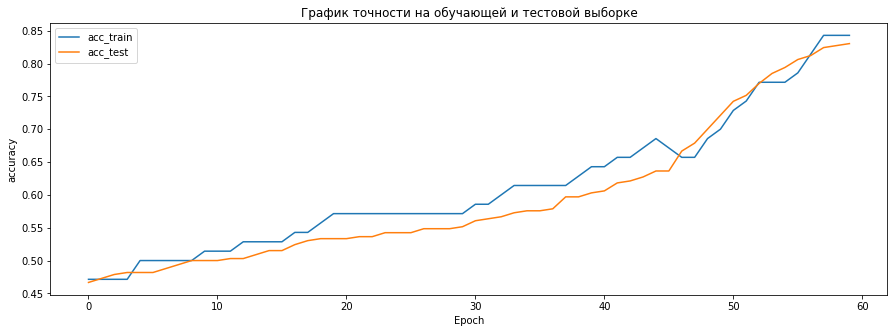

In [4]:
pl, ax = plt.subplots()
pl.set_size_inches((15,5))
ax.set_title("График точности на обучающей и тестовой выборке")
ax.plot(acc_train_m, label='acc_train')
ax.plot(acc_test_m, label='acc_test')
ax.set_xlabel("Epoch")
ax.set_ylabel("accuracy")
ax.legend()
pl.show()


**Задание 2**: Попробуйте решить задачу классификации на датасете MNIST с помощью этого кода. Подсказка: используйте `softmax_crossentropy_with_logits` или `sparse_softmax_cross_entropy_with_logits` в качестве функции ошибки. При этом в первом случае на выход сети необходимо подавать целевые значения в формате *one hot encoding*, а во втором - в виде целочисленного номера класса.

In [5]:
#load mnist data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = tf.cast(x_train / 255.,tf.float32)
x_test = tf.cast(x_test / 255.,tf.float32)
y_train = tf.keras.utils.to_categorical(y_train, 10, dtype='float32')
y_test = tf.keras.utils.to_categorical(y_test, 10, dtype='float32')
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train.astype(np.float32)))
dataset = dataset.batch(batch_size=150)

11493376/11490434 [==============================] - 0s 0us/step


In [6]:
optimizer = tf.keras.optimizers.Adam(0.01)

learning_rate = 0.05

W = tf.Variable(tf.random.normal(shape=(28*28,10)))
b = tf.Variable(tf.zeros(shape=(10,),dtype=tf.float32))

@tf.function
def train_on_batch(x_train, x_test, y_train, y_test):
  vars = [W, b]
  with tf.GradientTape() as tape:
    z = tf.matmul(x_train, W) + b
    z_test = tf.nn.softmax(tf.matmul(x_test, W) + b)

    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_train,logits=z))
    z = tf.nn.softmax(z)

    correct_prediction_test = tf.equal(tf.argmax(z_test,1), tf.argmax(y_test,1))
    acc_test = tf.reduce_mean(tf.cast(correct_prediction_test, tf.float32))

    correct_prediction_train = tf.equal(tf.argmax(z,1), tf.argmax(y_train,1))
    acc_train = tf.reduce_mean(tf.cast(correct_prediction_train, tf.float32))

    grads = tape.gradient(loss, vars)
    optimizer.apply_gradients(zip(grads,vars))
  return loss, acc_test, acc_train

acc_train_m = list()
acc_test_m = list()
for epoch in range(10):
  for step, (x, y) in enumerate(dataset):
    loss, acc_test, acc_train = train_on_batch(tf.reshape(x,(-1,28*28)), tf.reshape(x_test,(-1,28*28)), tf.reshape(y,(-1,10)), tf.reshape(y_test,(-1,10)))
  acc_train_m.append(acc_train)
  acc_test_m.append(acc_test)
  print('Epoch %d: last batch loss = %.4f, acc_train = %.4f, acc_test = %.4f' % (epoch, float(loss), acc_train, acc_test))

Epoch 0: last batch loss = 0.6319, acc_train = 0.9133, acc_test = 0.8702
Epoch 1: last batch loss = 0.4671, acc_train = 0.9333, acc_test = 0.8922
Epoch 2: last batch loss = 0.3835, acc_train = 0.9333, acc_test = 0.8990
Epoch 3: last batch loss = 0.3343, acc_train = 0.9400, acc_test = 0.9037
Epoch 4: last batch loss = 0.3053, acc_train = 0.9333, acc_test = 0.9068
Epoch 5: last batch loss = 0.2857, acc_train = 0.9400, acc_test = 0.9089
Epoch 6: last batch loss = 0.2706, acc_train = 0.9333, acc_test = 0.9104
Epoch 7: last batch loss = 0.2577, acc_train = 0.9400, acc_test = 0.9118
Epoch 8: last batch loss = 0.2464, acc_train = 0.9400, acc_test = 0.9131
Epoch 9: last batch loss = 0.2364, acc_train = 0.9467, acc_test = 0.9132


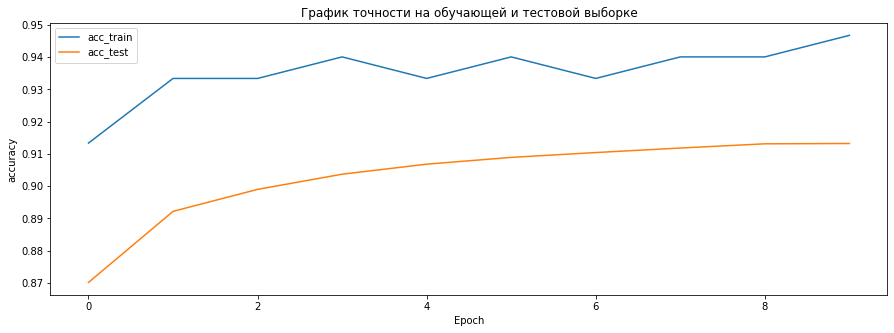

In [7]:
pl, ax = plt.subplots()
pl.set_size_inches((15,5))
ax.set_title("График точности на обучающей и тестовой выборке")
ax.plot(acc_train_m, label='acc_train')
ax.plot(acc_test_m, label='acc_test')
ax.set_xlabel("Epoch")
ax.set_ylabel("accuracy")
ax.legend()
pl.show()

**Задание 3**: 
Используйте Keras для обучения классификатора на сети MNIST. При этом:
* Обратите внимание, что в keras заложены типовые датасеты, включая MNIST. Для обращения к нему достаточно пары строчек кода (см, например, [тут](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist))
* Попробуйте несколько конфигураций сети с несколькими полносвязными слоями, передаточными функциями, и разным количеством нейронов

Какой точности вам удалось достичь? (Примерно 0.93 на второй модели) 


In [8]:
#load mnist data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = tf.cast(x_train / 255.,tf.float32)
x_test = tf.cast(x_test / 255.,tf.float32)

y_train = tf.keras.utils.to_categorical(y_train, 10, dtype='float32')
y_test = tf.keras.utils.to_categorical(y_test, 10, dtype='float32')

In [9]:
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


Первая модель со слоями *128 relu* и *10 softmax*

In [10]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(28, 28, 1)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128,activation='relu'))
model.add(tf.keras.layers.Dense(10,activation='softmax'))


model.compile(optimizer=tf.keras.optimizers.Adam(0.1), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()
h = model.fit(x_train, y_train, batch_size=256, epochs=25, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
188/188 [==============================] - 1s 5ms/step - loss: 0.8473 - accuracy: 0.8269 - val_loss: 0.3402 - val_accuracy: 0.9138
Epoch 2/25
188/188 [==============================] - 1s 4ms/step - loss: 0.3671 - accuracy: 0.9086 - val_loss: 0.3025 - val_accuracy: 0.9277
Epoch 3/25
188/188 [==============================] - 1s 4ms/step - loss: 0.3200 - accuracy: 0.9

In [11]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.9443795680999756
Test accuracy: 0.8030999898910522


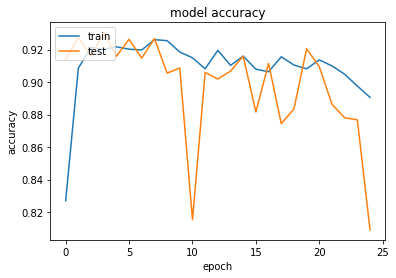

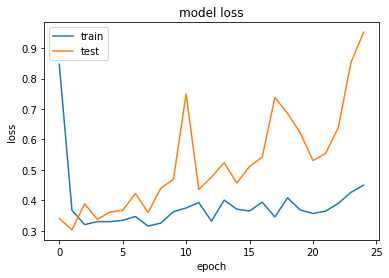

In [12]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Вторая модель со слоями *128 sigmoid* и *10 softmax*

In [13]:
model_2 = tf.keras.models.Sequential()
model_2.add(tf.keras.Input(shape=(28, 28, 1)))
model_2.add(tf.keras.layers.Flatten())
model_2.add(tf.keras.layers.Dense(128,activation='sigmoid'))
model_2.add(tf.keras.layers.Dense(10,activation='softmax'))


model_2.compile(optimizer=tf.keras.optimizers.Adam(0.1), loss="categorical_crossentropy", metrics=["accuracy"])
model_2.summary()
h_2 = model_2.fit(x_train, y_train, batch_size=256, epochs=25, validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
188/188 [==============================] - 1s 5ms/step - loss: 0.6301 - accuracy: 0.8210 - val_loss: 0.3004 - val_accuracy: 0.9099
Epoch 2/25
188/188 [==============================] - 1s 4ms/step - loss: 0.2896 - accuracy: 0.9137 - val_loss: 0.2429 - val_accuracy: 0.9287
Epoch 3/25
188/188 [==============================] - 1s 4ms/step - loss: 0.2486 - accuracy: 0

In [14]:
score = model_2.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.22711071372032166
Test accuracy: 0.9398000240325928


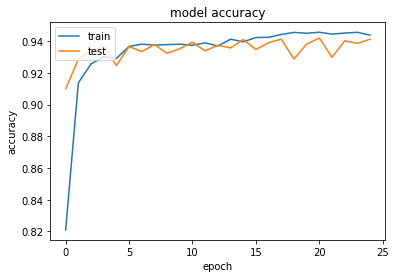

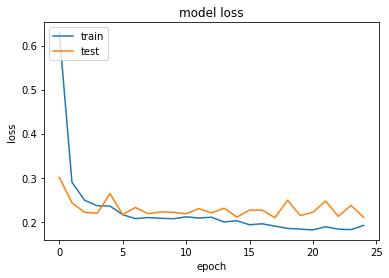

In [15]:
plt.plot(h_2.history['accuracy'])
plt.plot(h_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(h_2.history['loss'])
plt.plot(h_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Третья модель со слоями: *128 sigmoid, 64 relu, 10 softmax*

In [16]:
model_3 = tf.keras.models.Sequential()
model_3.add(tf.keras.Input(shape=(28, 28, 1)))
model_3.add(tf.keras.layers.Flatten())
model_3.add(tf.keras.layers.Dense(128,activation='sigmoid'))
model_3.add(tf.keras.layers.Dense(64,activation='relu'))
model_3.add(tf.keras.layers.Dense(10,activation='softmax'))


model_3.compile(optimizer=tf.keras.optimizers.Adam(0.1), loss="categorical_crossentropy", metrics=["accuracy"])
model_3.summary()
h_3 = model_3.fit(x_train, y_train, batch_size=128, epochs=25, validation_split=0.2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
375/375 [==============================] - 2s 4ms/step - loss: 1.0639 - accuracy: 0.6705 - val_loss: 0.5883 - val_accuracy: 0.8604
Epoch 2/25
375/375 [==============================] - 1s 4ms/step - loss: 0.6303 - accuracy: 0.8449 - va

In [17]:
score = model_3.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.4117642939090729
Test accuracy: 0.9045000076293945


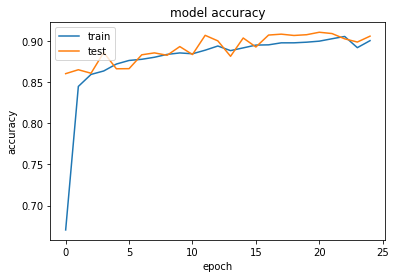

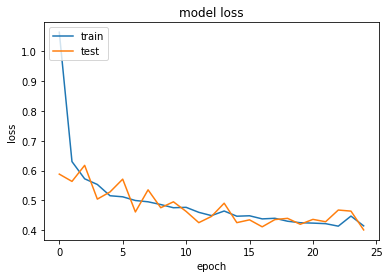

In [18]:
plt.plot(h_3.history['accuracy'])
plt.plot(h_3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(h_3.history['loss'])
plt.plot(h_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Все модели тренировались одинаковое количество эпох, на одинаковом размере батча, с одинаковым объёмом выборки для валидации. Все условия были равными (за исключением начальной инициализации весов). 

На графике ниже видим, что лучше всего отработала вторая модель. Вторая модель отличается от первой только функцией активации, следовательно, sigmoid отработал на данном датасете лучше, чем relu. Третья модель использовала дополнительный слой relu в отличии от второй модели, что привело к ухудшению результата (за 25 эпох).

---

Первая модель с двумя слоями *128 relu* и *10 softmax*

Вторая модель со слоями *128 sigmoid* и *10 softmax*

Третья модель со слоями: *128 sigmoid, 64 relu, 10 softmax*

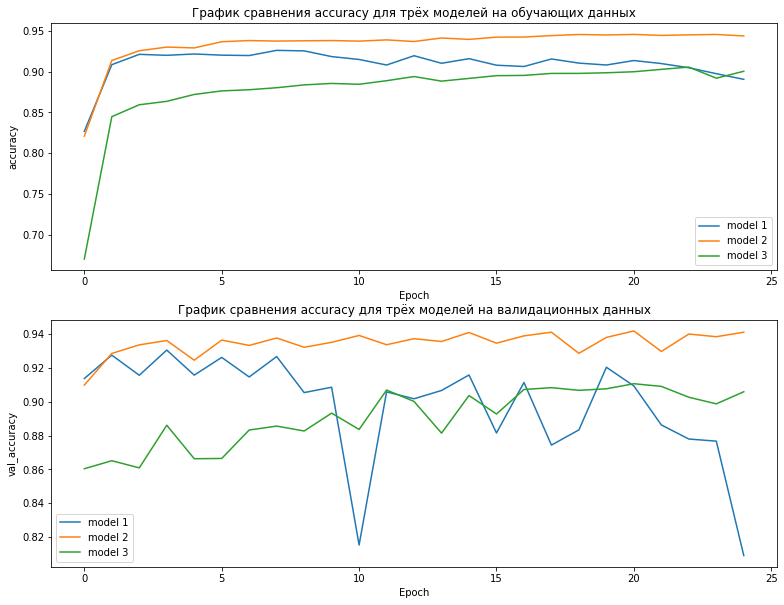

In [22]:
plt.rcParams["figure.figsize"] = (13,10)
pl, ax = plt.subplots(2)
ax[0].set_title("График сравнения accuracy для трёх моделей на обучающих данных")
ax[0].plot(h.history['accuracy'], label='model 1')
ax[0].plot(h_2.history['accuracy'], label='model 2')
ax[0].plot(h_3.history['accuracy'], label='model 3')
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("accuracy")
ax[0].legend()

ax[1].set_title("График сравнения accuracy для трёх моделей на валидационных данных")
ax[1].plot(h.history['val_accuracy'], label='model 1')
ax[1].plot(h_2.history['val_accuracy'], label='model 2')
ax[1].plot(h_3.history['val_accuracy'], label='model 3')
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("val_accuracy")
ax[1].legend()

pl.show()